In [1]:
import torch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random


In [3]:
a, b = 2, 5
sigma = 0.1

xs = np.linspace(0.2, 0.8, 5000)

rdms = np.random.normal(0, sigma, len(xs))
ys = (a * xs + b + rdms)

Text(0.5, 1.0, 'Training data (not all)')

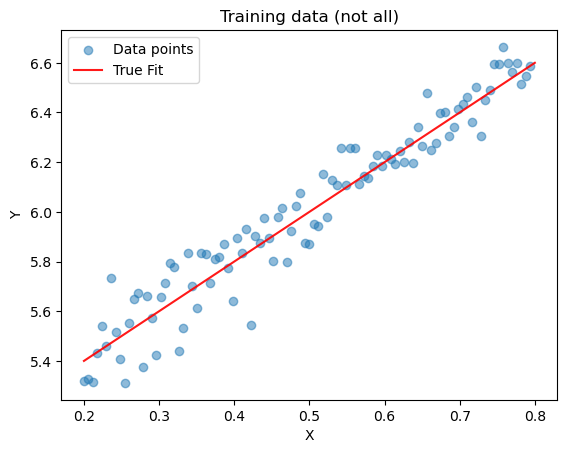

In [4]:
plt.scatter(xs[::50], ys[::50], alpha=0.5, label='Data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.plot([xs[0], xs[-1]], [a*xs[0]+b, a*xs[-1]+b], alpha=0.9, label='True Fit', color='red')
plt.legend()
plt.title('Training data (not all)')

In [5]:
xs = np.expand_dims(xs, -1).astype('float32')
ys = np.expand_dims(ys, -1).astype('float32')

In [6]:
pytorch_xs = torch.from_numpy(xs)
pytorch_ys = torch.from_numpy(ys)

In [7]:
train = torch.utils.data.TensorDataset(pytorch_xs, pytorch_ys)

In [8]:
from torch.utils.data import DataLoader

In [9]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)


In [10]:
train_features, train_labels = next(iter(train_dataloader))

In [11]:
train_features.shape

torch.Size([64, 1])

## Model 

In [12]:
from torch.nn import functional as F
from torch import nn
from lightning import LightningModule, Trainer

In [13]:
class TorchNeuron(LightningModule):

    def __init__(self):
        super().__init__()
        
        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = torch.nn.Linear(1, 1, bias=True)

    def forward(self, x):
        batch_size, channels = x.size()
        
        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        
        return x
      
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.005)

In [14]:
net = TorchNeuron()

## Try non trained network

In [15]:
out = net(train_features)

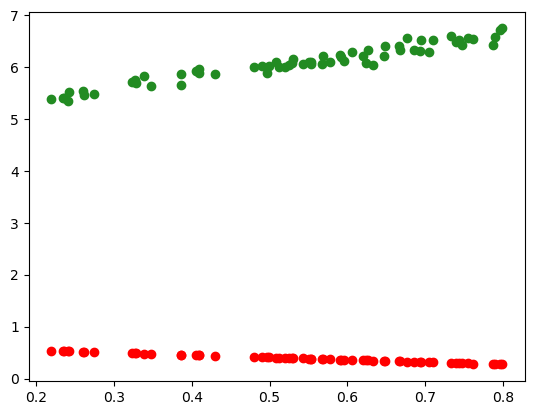

In [16]:
plt.scatter(train_features, train_labels, color='forestgreen')
plt.scatter(train_features, out.detach().numpy(), color='red')

## Training

In [17]:
trainer = Trainer(max_epochs=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/miniconda/base/envs/pytorch_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [18]:
h = trainer.fit(net, train_dataloader)


  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 2     
-----------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/pytorch_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [19]:
test_features, test_labels = next(iter(train_dataloader))
out_test = net(test_features)

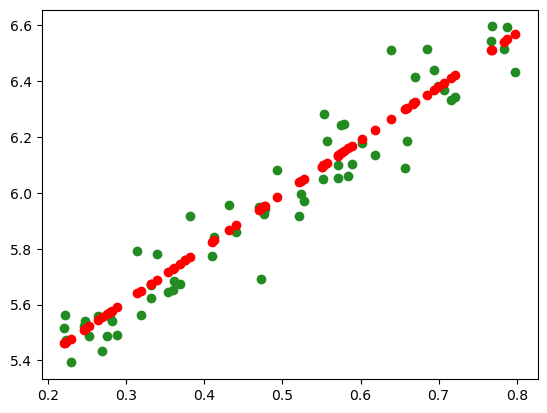

In [20]:
plt.scatter(test_features, test_labels, color='forestgreen')
plt.scatter(test_features, out_test.detach().numpy(), color='red')